In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')#TODO change helper.py file so inharmoniicity is from . and also change midi file so sharedtypes is in lib rather than midi folder
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [2]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_to_next = dict_to_frequency_list(dic)
print(score)

[[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392]

In [6]:
print(time_to_next)



[196.61458333333331, 197.91666666666669, 197.91666666666669, 196.61458333333326, 197.91666666666674, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666674, 196.61458333333326, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666788, 196.61458333333212, 197.91666666666788, 197.91666666666606, 197.91666666666606,

In [3]:
# Create cov_dict

cov_dict = {}
sample_length = 500
sample_rate = 44100
M=9
transition=0.465
v=2.37
sigma_f=5
sigma_n=0.1
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
max_d = 50

for state in score[:20]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=transition, v=v) + sigma_n**2 * np.eye(sample_length)

In [4]:
# Update: don't even need a transition matrix tbh!!!

# Note 
K = len(score[:130]) # The number of states, K
transition = np.full((K, K, max_d), -np.inf) 
for i in range(K-1): # Populate transition probabilities except final row
    transition[i][i][:], transition[i][i+1][:] = np.log(0.5), np.log(0.5)
transition[-1][-1][:] = np.log(1) # Update final row so transition probability is one, to itself

In [25]:
print(transition[2,4,7])

-inf


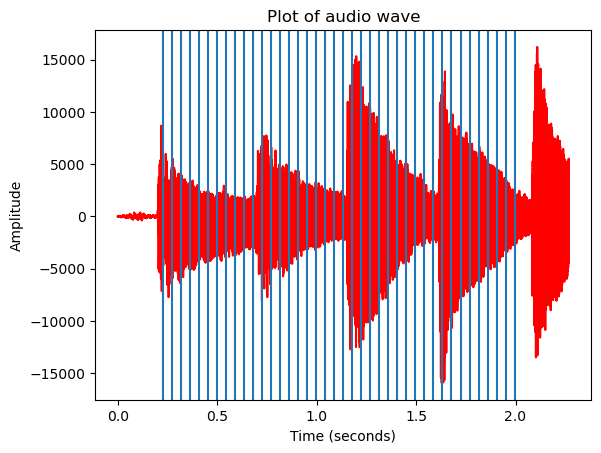

In [5]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 2000

show = 100000
offset = 10000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [57]:
print(time_to_next)

[196.61458333333331, 197.91666666666669, 197.91666666666669, 196.61458333333326, 197.91666666666674, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666674, 196.61458333333326, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666788, 196.61458333333212, 197.91666666666788, 197.91666666666606, 197.91666666666606,

In [37]:
p = 1/2.9
q = 1 - p
d = 4
advance_transition = np.sum([q**i * p for i in range(d)])
print(advance_transition)

0.8157436718927837


data dfit values:  -4132465201090.9136 2.829818671031211e+24 5492112231493.673
whole lml values:  -4132465199362.6772 2.829818671031187e+24 5492112231493.664


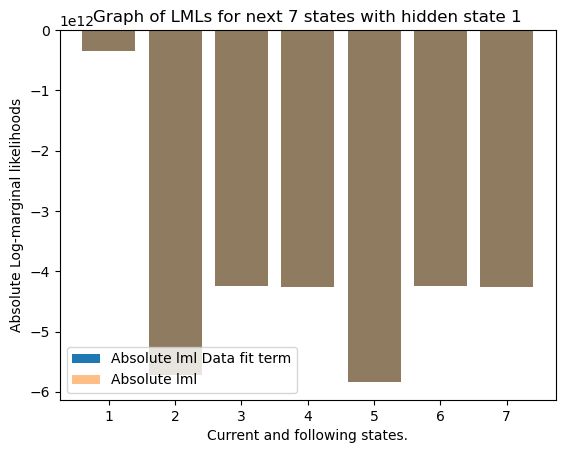

[-3.47724755e+11 -5.71616594e+12 -4.24697996e+12 -4.26478439e+12
 -5.83983699e+12 -4.24697996e+12 -4.26478439e+12]


/var/folders/n4/k97yk30s1wn32d7y6729kph80000gn/T/ipykernel_6835/1936766358.py:26: RuntimeWarning: invalid value encountered in power
  probs_data_fit = np.array(probs_data_fit)**0.01


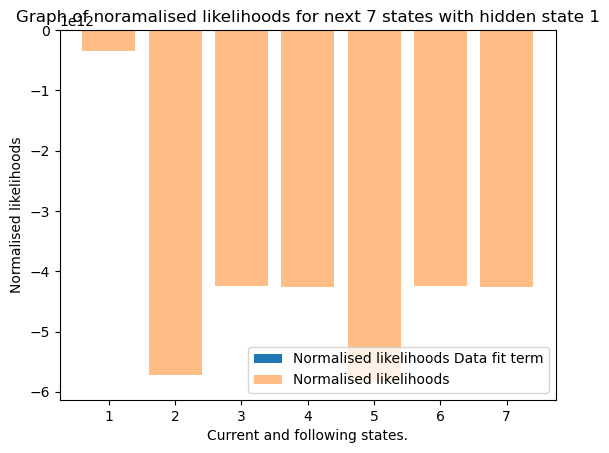

In [12]:
 # Trying by processing methods (not normalisation)

sample_length = len(audio_data[0])
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
freqs = [100, 150, 200, 250, 261, 275,300, 350, 400]
probs = []
probs_data_fit = []
for f in range(len(score[:7])):
    lml = -helper.stable_nlml(time_samples, audio_data[6], M=9, normalised=False, f=score[f], T=0.465, v=2.37)
    lml_data_fit = -helper.relative_nlml(time_samples, audio_data[6], M=9, normalised=False, f=score[f], T=0.465, v=2.37)
    probs.append(lml)
    probs_data_fit.append(lml_data_fit)
print("data dfit values: ",np.mean(probs_data_fit), np.var(probs_data_fit), np.max(probs_data_fit)-np.min(probs_data_fit))
print("whole lml values: ",np.mean(probs), np.var(probs), np.max(probs)-np.min(probs))
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Absolute lml Data fit term")
plt.bar([1,2,3,4,5,6,7], probs, alpha=0.5, label="Absolute lml")
plt.legend()

plt.xlabel("Current and following states.")
plt.ylabel("Absolute Log-marginal likelihoods")
plt.title("Graph of LMLs for next 7 states with hidden state 1")
plt.show()


probs = np.array(probs)**1
probs_data_fit = np.array(probs_data_fit)**0.01
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Normalised likelihoods Data fit term")
plt.bar([1,2,3,4,5,6,7], probs,alpha=0.5, label="Normalised likelihoods")

plt.xlabel("Current and following states.")
plt.ylabel("Normalised likelihoods")
plt.title("Graph of noramalised likelihoods for next 7 states with hidden state 1")
plt.legend()
print(probs)

data dfit values:  -194544418905918.84 1.3653891090842892e+28 279064052385873.5
whole lml values:  -194544418904190.6 1.36538910908429e+28 279064052385873.56


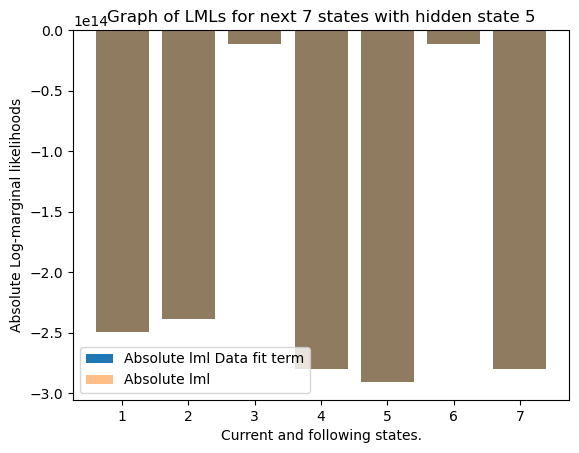

[0.83278285 0.83939138 0.99139832 0.81419878 0.80770355 0.99139832
 0.81419878]


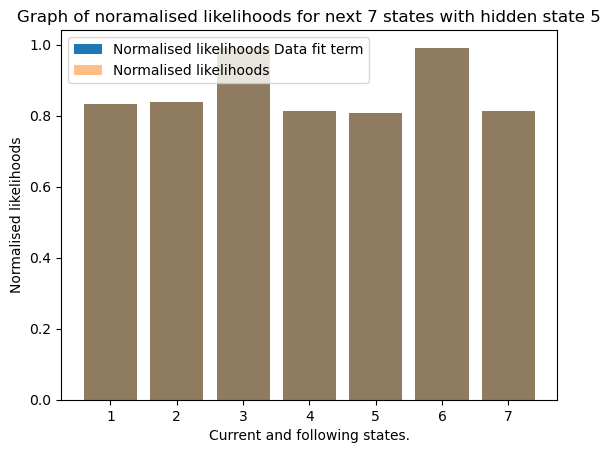

In [8]:
 # Trying by normalisation

sample_length = len(audio_data[0])
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
freqs = [100, 150, 200, 250, 261, 275,300, 350, 400]
probs = []
probs_data_fit = []
for f in range(len(score[:7])):
    lml = -helper.stable_nlml(time_samples, audio_data[52], M=9,   normalised=False, f=score[f], T=0.465, v=2.37)
    lml_data_fit = -helper.relative_nlml(time_samples, audio_data[52], M=9,   normalised=False, f=score[f], T=0.465, v=2.37)
    probs.append(lml)
    probs_data_fit.append(lml_data_fit)
print("data dfit values: ",np.mean(probs_data_fit), np.var(probs_data_fit), np.max(probs_data_fit)-np.min(probs_data_fit))
print("whole lml values: ",np.mean(probs), np.var(probs), np.max(probs)-np.min(probs))
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Absolute lml Data fit term")
plt.bar([1,2,3,4,5,6,7], probs, alpha=0.5, label="Absolute lml")
plt.legend()

plt.xlabel("Current and following states.")
plt.ylabel("Absolute Log-marginal likelihoods")
plt.title("Graph of LMLs for next 7 states with hidden state 5")

plt.show()
probs = np.exp(np.array(probs)/np.sum(np.abs(probs)))
probs_data_fit = np.exp(np.array(probs_data_fit)/np.sum(np.abs(probs_data_fit)))
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Normalised likelihoods Data fit term")
plt.bar([1,2,3,4,5,6,7], probs,alpha=0.5, label="Normalised likelihoods")

plt.xlabel("Current and following states.")
plt.ylabel("Normalised likelihoods")
plt.title("Graph of noramalised likelihoods for next 7 states with hidden state 5")
plt.legend()
print(probs)

In [64]:
def viterbi(y: List[np.ndarray], states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = len(states) # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    max_s = 0
    path = []
    w = 6
    chunk = 0
    step = w //3
    counter = []
    conversion_rate = 56 # TODO need to make this more general... may eit should depend on the MIDI suggestion...?
    d = 1 # d tracks the duration number (ie this incremements each time we perform a self transition)

    
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    gamma[0,0] = 1 * lml # Initialise probability of first audio sample with state 1

    # Iterate through observations
    for i in range(1, n):
        k0_index = chunk * step
        probs = []

        # Calculate transition probabilities TODO this is way too small relatively
        expected = conversion_rate * time_to_next[max_s]/1000
        print('expected',expected)
        p = 1 / expected # probability 
        q = 1 - p
        advance_transition = np.log(np.sum([q**i * p for i in range(d)]))
        self_transition = np.log(1 - advance_transition)
        print(advance_transition, self_transition)

        for k in range(k0_index, k0_index + w):

            lml = -helper.relative(time_samples, y[i], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
            print(lml)
            probs.append(lml)

            same_state = lml + gamma[k,i-1] + self_transition
            advance_state = lml + gamma[k-1, i-1] +  advance_transition

            if same_state >= advance_state:
                gamma[k, i] = same_state
                delta[k, i] = k
            else:
                gamma[k, i] = advance_state
                delta[k, i] = k - 1
        
        
        probs = np.exp(np.array(probs)/np.sum(np.abs(probs)))
        new_s = np.argmax(gamma[:,i])

        if new_s == max_s:
            d += 1 # increment count 
        else:
            counter.append(d)
            conversion_rates = 1000 * np.array(counter)/ np.array(time_to_next[:len(counter)]) # Multiply by 1000 to make seconds
            conversion_rate =  np.mean(conversion_rates) # Conversion is how many durations counts d per second. We take the running mean average
            d = 1
        max_s = new_s
        print(max_s, flush=True)
        path.append(max_s)
        if max_s >= k0_index + w - step:
            chunk += 1
            print('new chunk!: ', chunk)
    
    # Build the optimal path, for comparison to live output
    optimal_path = np.zeros(n, 'B')
    optimal_path[-1] = np.argmax(gamma[:, n-1])

    for i in reversed(range(1, n)):
        optimal_path[i-1] = delta[optimal_path[i], i]

    return path, optimal_path,counter


path, optimal, counter = viterbi(audio_data[:90],  score[:90], cov_dict=cov_dict )
print(path, optimal)

    

expected 11.010416666666666
-2.398841794402401 1.2234347248829895
-1561420052.1580987
-108508026932.61858
-167022873386.71756
-196776503612.13596
-207055390663.41678
-167022873386.71756
0
expected 11.010416666666666
-1.7521695793590848 1.012389538579282
-574575751.8946972
-92098990387.5428
-127952293572.21027
-139331844296.6832
-168043599604.51917
-127952293572.21027
0


expected 11.010416666666666
-1.3924253607449146 0.8723076466775211
-1355551870.495605
-66765051548.29758
-64628996762.69071
-77095967396.55746
-108328419861.4857
-64628996762.69071
0
expected 11.010416666666666
-1.14971180551547 0.7653337892085859
-402791056.93826574
-45334622260.64284
-41691143758.920715
-54795169139.618256
-76219180522.79462
-41691143758.920715
0
expected 11.010416666666666
-0.9707867741566345 0.6784328407643179
-169017067.4427331
-41447564309.34176
-39377932740.94316
-45918699414.74146
-62556643262.05175
-39377932740.94316
0
expected 11.010416666666666
-0.8319367761790398 0.6053737548371252
-1609316841.0390399
-32942419969.429314
-38591661933.51512
-41024812709.66888
-49584071860.631584
-38591661933.51512
0
expected 11.010416666666666
-0.7205143784193191 0.5426233033371989
-1424761676.5659685
-34873817507.14181
-33725224385.689888
-30081202091.800495
-45613442786.26322
-33725224385.689888
0
expected 11.010416666666666
-0.6289723082936377 0.48794933026954995
-4049667

In [30]:
print(counter)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 6, 2, 6, 3, 2, 3, 5, 3]


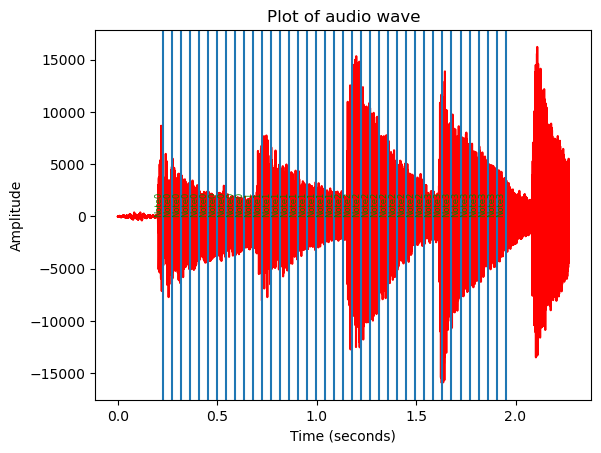

In [53]:
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:39]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{path[_]}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    